#imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

import os
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from sklearn.metrics import auc,roc_auc_score
import time
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models
import torchvision.utils as utils
# device = torch.device("cpu")

import warnings
warnings.filterwarnings("ignore")

In [2]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score
import torchvision.utils as utils

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

#dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# define transforms
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

])
# get data
train_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/200X/train", transform=transform)
test_data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/200X/test", transform=transform)
print(f'train dataset len : {len(train_data)}')
print(f"test dataset len: {len(test_data)}")

train dataset len : 1652
test dataset len: 401


In [10]:
# data loaders
# Create data loaders for our datasets; shuffle for training, not for validation
batch_size_train=16
batch_size_test=32

from torch.utils.data import random_split

dataset_size = len(train_data)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

print(len(train_dataset), len(val_dataset))
print(len(test_data))

# Create data loaders for train and validation sets
training_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)

test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

1322 330
401


In [7]:
data_loaders = {'train': training_loader, 'val': validation_loader}

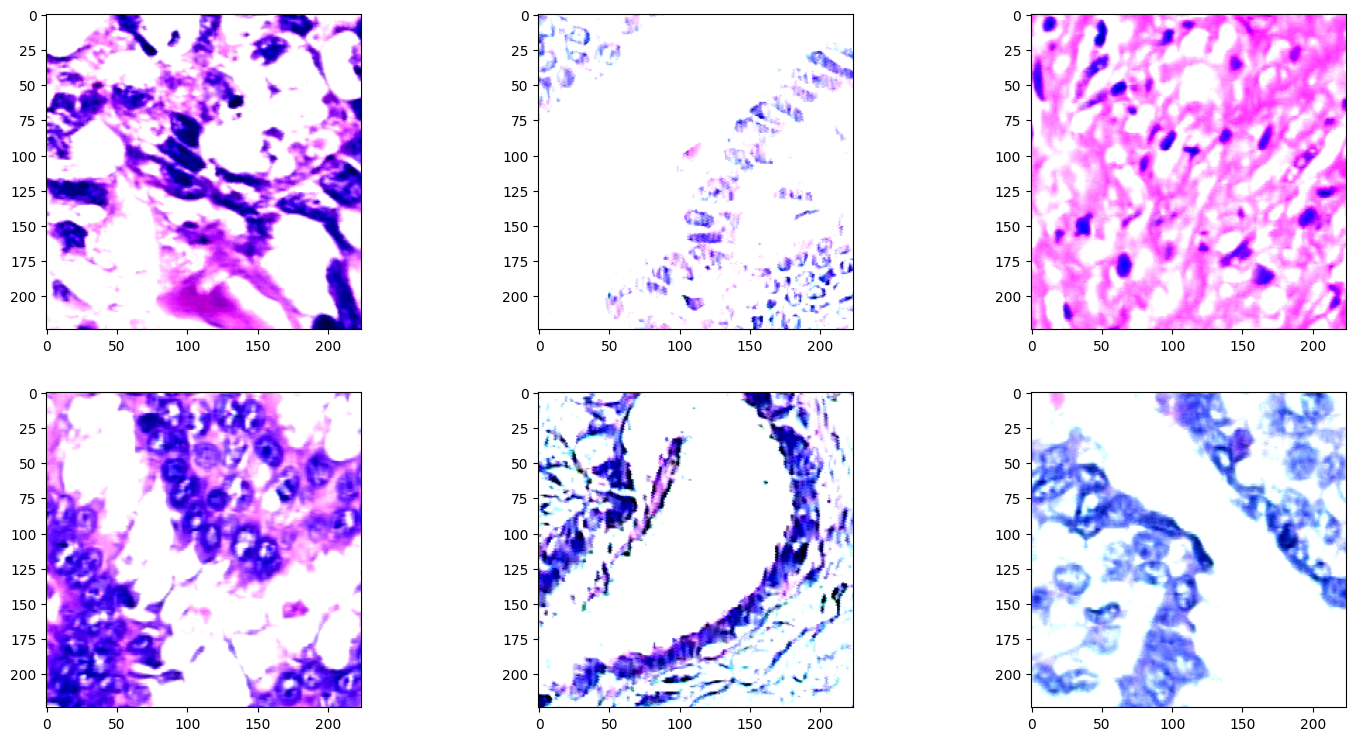

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(18, 9))
for i, batch in enumerate(training_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

In [12]:
class_names = train_data.classes

In [13]:
class_names

['benign', 'malignant']

#model

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=1.3, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [15]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)

       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)


        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()

        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [16]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH

        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

#train

In [17]:
model = AttnVGG(num_classes=2, normalize_attn=True)
model=model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:09<00:00, 59.1MB/s]


In [18]:
criterion = nn.CrossEntropyLoss() #FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.01)

In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
device = torch.device("cpu")

In [19]:
start_time = time.time()

from sklearn.metrics import roc_auc_score


epochs = 5
train_losses = []
test_losses = []
train_accuracy = []  # Store train accuracy
val_accuracy = []    # Store validation accuracy

for i in range(epochs):
    train_preds = []
    train_targets = []
    accuracy_train = []
    loss_epoch_train = []
    loss_epoch_test = []

    for b, (X_train, y_train) in tqdm(enumerate(training_loader), total=len(training_loader)):
        X_train, y_train = X_train.cuda(), y_train.cuda()

        b += 1
        y_pred, _, _ = model(X_train)
        loss = criterion(torch.sigmoid(y_pred.type(torch.FloatTensor)), y_train.type(torch.LongTensor))
        loss_epoch_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate train accuracy
        _, predicted = torch.max(y_pred, 1)
        correct = (predicted == y_train).sum().item()
        accuracy_train.append(correct / y_train.size(0))  # Calculate accuracy per batch

    train_accuracy.append(np.mean(accuracy_train))  # Store average train accuracy for the epoch
    train_losses.append(np.mean(loss_epoch_train))
    print(f'epoch: {i:2}   loss: {np.mean(loss_epoch_train):10.8f} Accuracy: {np.mean(accuracy_train):10.8f} ')

     # For visualization purpose
    if (i == 1) and (b == 19):
      I_train = utils.make_grid(X_train[0:8,:,:,:], nrow=8, normalize=True, scale_each=True)
    # Assuming visualize_attention is a function for visualization
      __, a1, a2 = model(X_train[0:8,:,:,:])


    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(validation_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()

            y_val, _, _ = model(X_test)
            loss = criterion(torch.sigmoid(y_val.type(torch.FloatTensor)), y_test.type(torch.LongTensor))
            loss_epoch_test.append(loss.item())

            # Calculate validation accuracy
            _, predicted_val = torch.max(y_val, 1)
            correct_val = (predicted_val == y_test).sum().item()
            val_accuracy.append(correct_val / y_test.size(0))  # Calculate accuracy per batch

        val_accuracy_epoch = np.mean(val_accuracy)  # Calculate average validation accuracy for the epoch
        val_accuracy.append(val_accuracy_epoch)  # Store average validation accuracy for the epoch
        test_losses.append(np.mean(loss_epoch_test))
        print(f'Epoch: {i} Val Loss: {np.mean(loss_epoch_test):10.8f} Val Accuracy: {val_accuracy_epoch:10.8f} ')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

100%|██████████| 83/83 [00:58<00:00,  1.41it/s]


epoch:  0   loss: 0.60300169 Accuracy: 0.71611446 
Epoch: 0 Val Loss: 0.49751867 Val Accuracy: 0.88863636 


100%|██████████| 83/83 [00:40<00:00,  2.03it/s]


epoch:  1   loss: 0.47980326 Accuracy: 0.85000000 
Epoch: 1 Val Loss: 0.44936812 Val Accuracy: 0.89379941 


100%|██████████| 83/83 [00:44<00:00,  1.88it/s]


epoch:  2   loss: 0.44719035 Accuracy: 0.87274096 
Epoch: 2 Val Loss: 0.45155252 Val Accuracy: 0.89592674 


100%|██████████| 83/83 [00:42<00:00,  1.97it/s]


epoch:  3   loss: 0.43227835 Accuracy: 0.89834337 
Epoch: 3 Val Loss: 0.42773763 Val Accuracy: 0.89555027 


100%|██████████| 83/83 [00:41<00:00,  2.00it/s]


epoch:  4   loss: 0.43540418 Accuracy: 0.88915663 
Epoch: 4 Val Loss: 0.41441240 Val Accuracy: 0.89796886 

Duration: 265 seconds


In [20]:
import matplotlib.pyplot as plt

# Your existing code...

def plot_images_and_predictions(model, data_loader):
    with torch.no_grad():
        for b, (X_batch, y_batch) in enumerate(data_loader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            y_pred, _, _ = model(X_batch)
            # Modify this as needed based on your use case
            if b == 0:
                images_to_plot = X_batch[:8, :, :, :]  # Take the first 8 images
                _, a1, a2 = model(images_to_plot)

                # Plotting code for the images and predictions
                fig, axes = plt.subplots(2, 4, figsize=(12, 6))
                for idx, ax in enumerate(axes.ravel()):
                    ax.imshow(images_to_plot[idx].cpu().permute(1, 2, 0).numpy())
                    ax.set_title(f"Prediction: {a1[idx].item()}, {a2[idx].item()}")  # Modify according to your output
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

#Visualizing Attention¶


In [21]:
def visualize_attention(I_train,a,up_factor,no_attention=False):
    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    img=cv2.resize(img,(466,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)

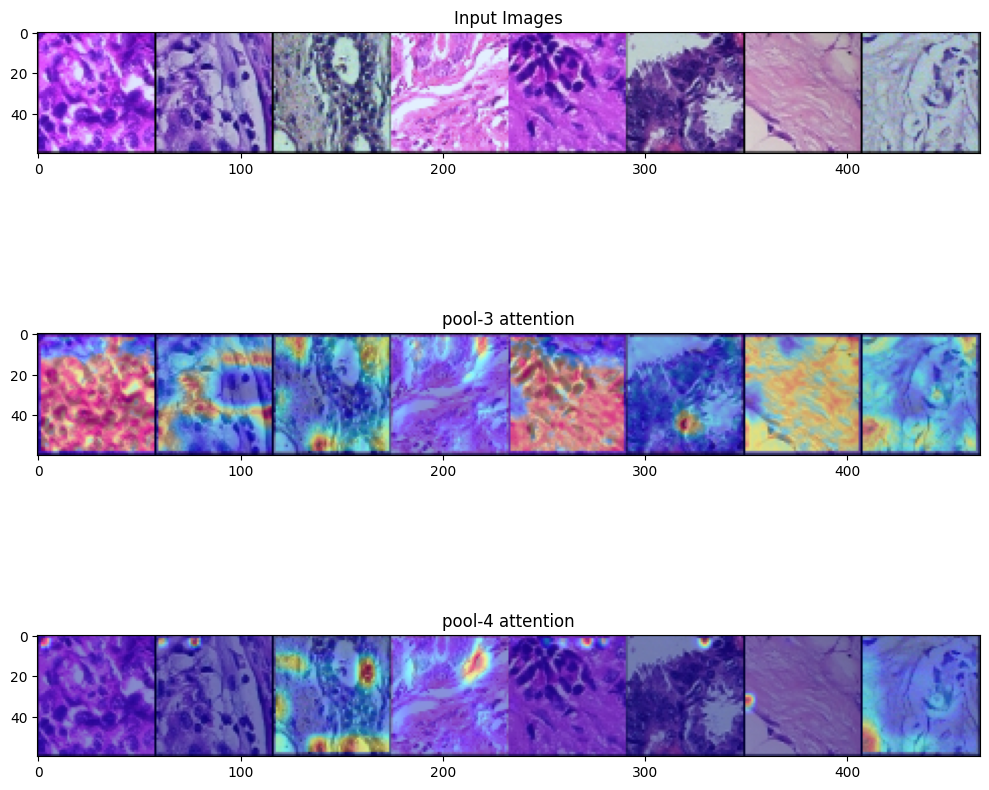

In [50]:
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnorm_img = img.cpu().numpy().transpose((1, 2, 0))
    unnorm_img = std * unnorm_img + mean
    unnorm_img = np.clip(unnorm_img, 0, 1)
    return unnorm_img

def combine_visualizations(I_train, a1, a2, up_factors=(2, 2, 4)):
    def visualize_attention(I_train, a, up_factor, no_attention=False):
      img = unnormalize(I_train)

# def combine_visualizations(I_train, a1, a2, up_factors=(2, 2, 4)):
#     def visualize_attention(I_train, a, up_factor, no_attention=False):
      img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
      if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
        attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
        attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
        attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
        attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
        attn = np.float32(attn) / 255
    # add the heatmap to the image
        img=cv2.resize(img,(466,60))
        if no_attention:
            return torch.from_numpy(img)
        else:
            vis = 0.6 * img + 0.4 * attn
            return torch.from_numpy(vis)
        # Your existing code for visualize_attention

    orig = visualize_attention(I_train, a1, up_factor=up_factors[0], no_attention=True)
    first = visualize_attention(I_train, a1, up_factor=up_factors[1], no_attention=False)
    second = visualize_attention(I_train, a2, up_factor=up_factors[2], no_attention=False)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.imshow(orig)
    ax2.imshow(first)
    ax3.imshow(second)
    ax1.set_title('Input Images')
    ax2.set_title('pool-3 attention')
    ax3.set_title('pool-4 attention')

    plt.tight_layout()
    plt.show()


# Assuming X_train_batch is your input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input data to the same device as the model

for batch_idx, (X_train_batch, _) in enumerate(training_loader):
    X_train_batch = X_train_batch.to(device)
    if batch_idx == 21:
        # Ensure the input batch is on the same device as the model
        X_train_batch = X_train_batch.to(device)

        I_train = utils.make_grid(X_train_batch[0:8, :, :, :], nrow=8, normalize=True, scale_each=True)
        _, a1, a2 = model(X_train_batch[0:8, :, :, :])
        break  # Stop the loop after getting the required batch

combine_visualizations(I_train, a1, a2, up_factors=(2, 2, 4))

In [23]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

test_losses = []
test_accuracy = []
test_auc = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for X_test, y_test in test_loader:  # Assuming test_loader is your test data loader
        X_test, y_test = X_test.cuda(), y_test.cuda()

        y_pred, _, _ = model(X_test)
        loss = criterion(torch.sigmoid(y_pred.type(torch.FloatTensor)), y_test.type(torch.LongTensor))
        test_losses.append(loss.item())

        # Calculate test accuracy
        _, predicted_test = torch.max(y_pred, 1)
        correct_test = (predicted_test == y_test).sum().item()
        test_accuracy.append(correct_test / y_test.size(0))  # Calculate accuracy per batch

        # Calculate AUC
        y_probs = torch.sigmoid(y_pred)
        y_probs = y_probs.cpu().detach().numpy()
        y_true = y_test.cpu().numpy()
        #auc = roc_auc_score(y_true, y_probs)
        test_auc.append(auc)

        # Calculate F1 score
        predicted_labels.extend(predicted_test.cpu().numpy())
        true_labels.extend(y_test.cpu().numpy())

test_accuracy = np.mean(test_accuracy)
# test_auc = np.mean(test_auc)
test_loss = np.mean(test_losses)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Test Loss: {test_loss:.8f}')
print(f'Test Accuracy: {test_accuracy:.8f}')
# print(f'Test AUC: {test_auc:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')

Test Loss: 0.42332914
Test Accuracy: 0.88998869
Precision: 0.88704319
Recall: 0.96389892
F1 Score: 0.92387543


In [24]:
classes = test_data.classes

In [25]:
class_names

['benign', 'malignant']

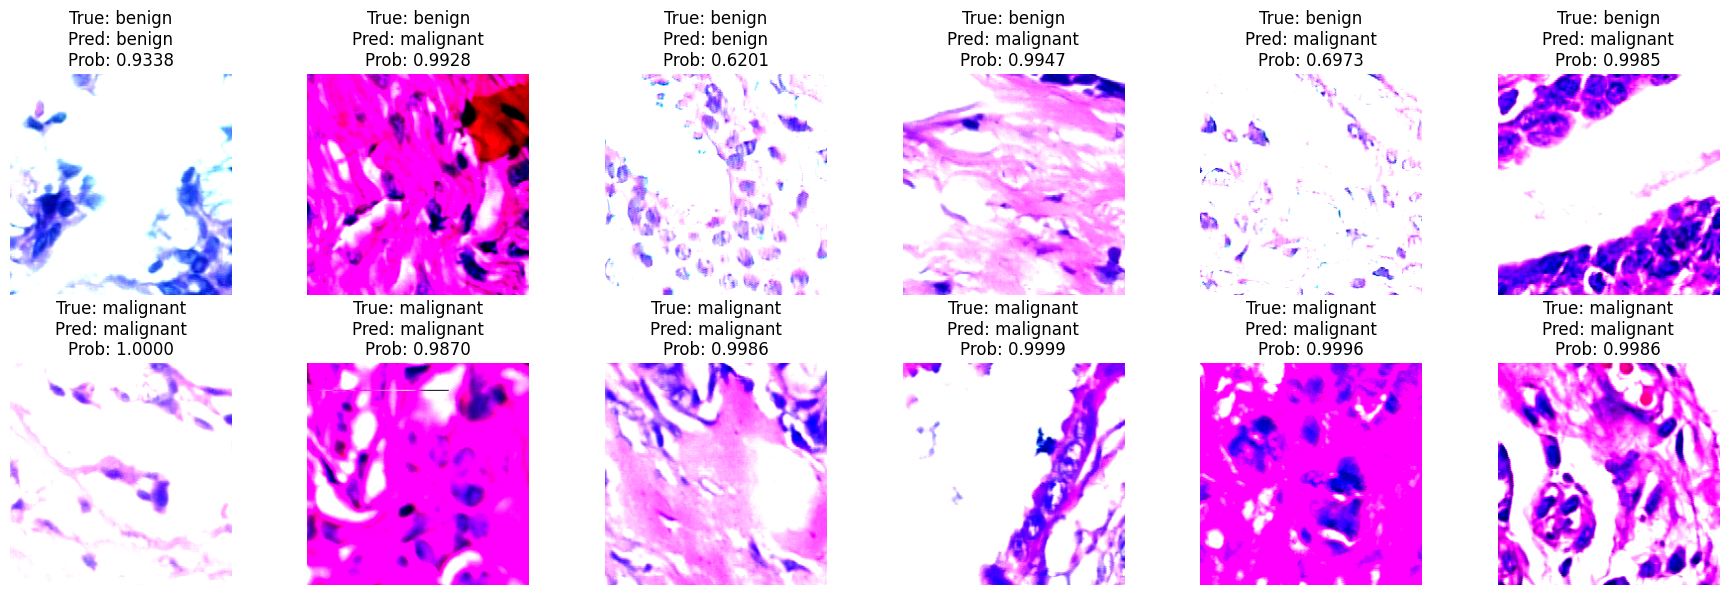

In [27]:
import torch
from torch.utils.data import SubsetRandomSampler

# Assuming 'test_loader' is your DataLoader for the test dataset

# Shuffle indices for random sampling
num_samples = len(test_loader.dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)

# Number of images to display per class
num_images_per_class = 6

# Randomly sample indices for benign and malignant classes
benign_indices = [ind for ind in indices if test_loader.dataset[ind][1] == 0][:num_images_per_class]
malignant_indices = [ind for ind in indices if test_loader.dataset[ind][1] == 1][:num_images_per_class]

# Combine indices for display
sample_indices = benign_indices + malignant_indices

# Create a subset sampler with the sampled indices
sampler = SubsetRandomSampler(sample_indices)

# Assuming 'class_names' contains the names corresponding to the class labels
plot_predicted_images_grid(model, torch.utils.data.DataLoader(test_loader.dataset, batch_size=1, sampler=sampler), class_names)


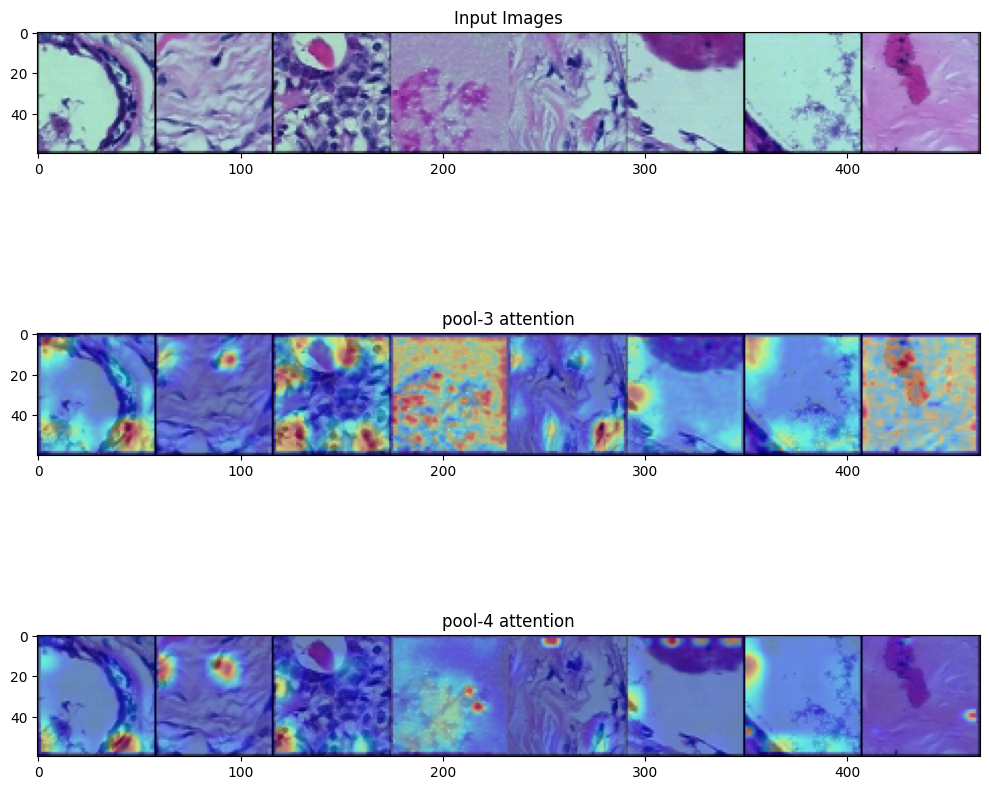

In [46]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

# Define your visualize_attention function
def visualize_attention(I_train, a, up_factor, no_attention=False):
    img = I_train.permute((1, 2, 0)).cpu().numpy()
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
        attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
        attn = attn.permute((1, 2, 0)).mul(255).byte().cpu().numpy()
        attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
        attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
        attn = np.float32(attn) / 255
        img = cv2.resize(img, (466, 60))
        if no_attention:
            return torch.from_numpy(img)
        else:
            vis = 0.6 * img + 0.4 * attn
            return torch.from_numpy(vis)

def combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4)):
    orig = visualize_attention(I_test, a1, up_factor=up_factors[0], no_attention=True)
    first = visualize_attention(I_test, a1, up_factor=up_factors[1], no_attention=False)
    second = visualize_attention(I_test, a2, up_factor=up_factors[2], no_attention=False)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.imshow(orig)
    ax2.imshow(first)
    ax3.imshow(second)
    ax1.set_title('Input Images')
    ax2.set_title('pool-3 attention')
    ax3.set_title('pool-4 attention')

    plt.tight_layout()
    plt.show()

# Assuming 'test_loader' contains your test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retrieve a batch of test data
for batch_idx, (X_test_batch, _) in enumerate(test_loader):
    X_test_batch = X_test_batch.to(device)
    if batch_idx == 0:  # Process the first batch of test data
        I_test = utils.make_grid(X_test_batch[0:8, :, :, :], nrow=8, normalize=True, scale_each=True)
        with torch.no_grad():
            _, a1, a2 = model(X_test_batch[0:8, :, :, :])
        break  # Stop the loop after processing the required batch

combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4))


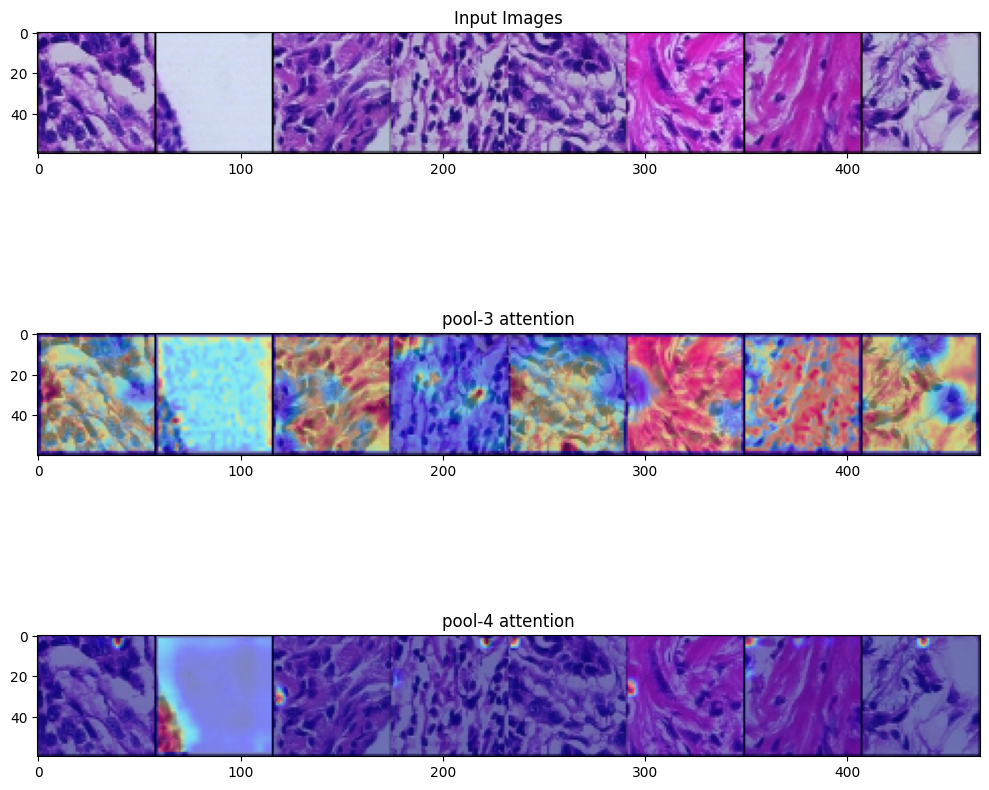

['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']
['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']


In [62]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnorm_img = img.cpu().numpy().transpose((1, 2, 0))
    unnorm_img = std * unnorm_img + mean
    unnorm_img = np.clip(unnorm_img, 0, 1)
    return unnorm_img

def combine_visualizations(I_train, a1, a2, up_factors=(2, 2, 4)):
    def visualize_attention(I_train, a, up_factor, no_attention=False):
     img = unnormalize(I_train)

# Define your visualize_attention function
# def visualize_attention(I_train, a, up_factor, no_attention=False):
     img = I_train.permute((1, 2, 0)).cpu().numpy()
     if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
        attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
        attn = attn.permute((1, 2, 0)).mul(255).byte().cpu().numpy()
        attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
        attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
        attn = np.float32(attn) / 255
        img = cv2.resize(img, (466, 60))
        if no_attention:
            return torch.from_numpy(img)
        else:
            vis = 0.5 * img + 0.5 * attn
            return torch.from_numpy(vis)
def combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4), true_labels=None, predictions=None):
    orig = visualize_attention(I_test, a1, up_factor=up_factors[0], no_attention=True)
    first = visualize_attention(I_test, a1, up_factor=up_factors[1], no_attention=False)
    second = visualize_attention(I_test, a2, up_factor=up_factors[2], no_attention=False)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.imshow(orig)
    ax2.imshow(first)
    ax3.imshow(second)
    ax1.set_title('Input Images')
    ax2.set_title('pool-3 attention')
    ax3.set_title('pool-4 attention')

    if true_labels:
        for i, true_label in enumerate(true_labels):
            ax1.text(10, 10 + i * 10, f'True label {i + 1}: {true_label}', color='white', backgroundcolor='black')

    if predictions:
        for i, pred in enumerate(predictions):
            ax1.text(10, 40 + i * 10, f'Prediction {i + 1}: {pred}', color='white', backgroundcolor='black')

    plt.tight_layout()
    plt.show()

# Assuming 'test_loader' contains your test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Retrieve a batch of test data
for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
    X_test_batch = X_test_batch.to(device)
    y_test_batch = y_test_batch.to(device)
    if batch_idx == 4:  # Process the first batch of test data
        I_test = utils.make_grid(X_test_batch[0:8, :, :, :], nrow=8, normalize=True, scale_each=True)
        with torch.no_grad():
            _, a1, a2 = model(X_test_batch[0:8, :, :, :])
            predictions, _, _ = model(X_test_batch[0:8, :, :, :])  # Get predictions
            predicted_labels = [class_names[pred] for pred in predictions.argmax(dim=1)]  # Assuming class_names contains label names
            true_labels = [class_names[label.item()] for label in y_test_batch[:8]]  # Assuming class_names contains label names
        break  # Stop the loop after processing the required batch

combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4))
print(predicted_labels)
print(true_labels)

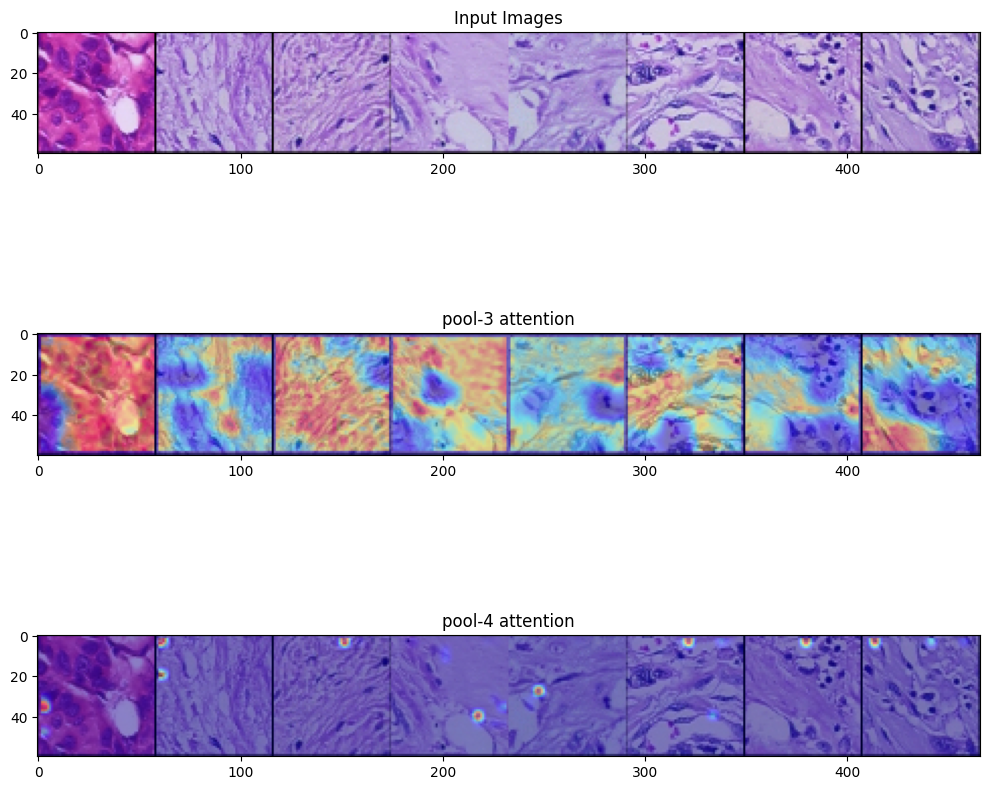

['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']
['malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']


In [66]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnorm_img = img.cpu().numpy().transpose((1, 2, 0))
    unnorm_img = std * unnorm_img + mean
    unnorm_img = np.clip(unnorm_img, 0, 1)
    return unnorm_img

def combine_visualizations(I_train, a1, a2, up_factors=(2, 2, 4)):
    def visualize_attention(I_train, a, up_factor, no_attention=False):
     img = unnormalize(I_train)

# Define your visualize_attention function
# def visualize_attention(I_train, a, up_factor, no_attention=False):
     img = I_train.permute((1, 2, 0)).cpu().numpy()
     if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
        attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
        attn = attn.permute((1, 2, 0)).mul(255).byte().cpu().numpy()
        attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
        attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
        attn = np.float32(attn) / 255
        img = cv2.resize(img, (466, 60))
        if no_attention:
            return torch.from_numpy(img)
        else:
            vis = 0.5 * img + 0.5 * attn
            return torch.from_numpy(vis)
def combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4), true_labels=None, predictions=None):
    orig = visualize_attention(I_test, a1, up_factor=up_factors[0], no_attention=True)
    first = visualize_attention(I_test, a1, up_factor=up_factors[1], no_attention=False)
    second = visualize_attention(I_test, a2, up_factor=up_factors[2], no_attention=False)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.imshow(orig)
    ax2.imshow(first)
    ax3.imshow(second)
    ax1.set_title('Input Images')
    ax2.set_title('pool-3 attention')
    ax3.set_title('pool-4 attention')

    if true_labels:
        for i, true_label in enumerate(true_labels):
            ax1.text(10, 10 + i * 10, f'True label {i + 1}: {true_label}', color='white', backgroundcolor='black')

    if predictions:
        for i, pred in enumerate(predictions):
            ax1.text(10, 40 + i * 10, f'Prediction {i + 1}: {pred}', color='white', backgroundcolor='black')

    plt.tight_layout()
    plt.show()

# Assuming 'test_loader' contains your test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Retrieve a batch of test data
for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
    X_test_batch = X_test_batch.to(device)
    y_test_batch = y_test_batch.to(device)
    if batch_idx == 9:  # Process the first batch of test data
        I_test = utils.make_grid(X_test_batch[0:8, :, :, :], nrow=8, normalize=True, scale_each=True)
        with torch.no_grad():
            _, a1, a2 = model(X_test_batch[0:8, :, :, :])
            predictions, _, _ = model(X_test_batch[0:8, :, :, :])  # Get predictions
            predicted_labels = [class_names[pred] for pred in predictions.argmax(dim=1)]  # Assuming class_names contains label names
            true_labels = [class_names[label.item()] for label in y_test_batch[:8]]  # Assuming class_names contains label names
        break  # Stop the loop after processing the required batch

combine_visualizations(I_test, a1, a2, up_factors=(2, 2, 4))
print(predicted_labels)
print(true_labels)